In [120]:
import numpy as np

def compute_eigenbasis(i, mat):
    """
    i-th eigenbasis
    """
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    u_i = U[:, i].reshape(-1, 1)
    v_i = Vt[i, :].reshape(1, -1)
    eigenbasis = np.dot(u_i, v_i)
    return eigenbasis

In [121]:

# d = 20
# rows, cols = d//2, d

# # Generate a random matrix
# random_matrix = np.random.rand(rows, cols)
# row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
# random_matrix = random_matrix / row_norms


# # top eigenspace, for example
# _ = compute_eigenbasis(0, random_matrix)

# U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
# kappa = S[0]/S[-1]
# print(kappa)

In [122]:
# Generate a poorly conditioned random matrix, enforce "halfing" eigenvalue sequence

d = 1000
col = d

kappa = 1/d**2 # want this to be "poly d"
s = [1]
while s[-1] > 2 * kappa:
  s += [s[-1]/2]

row = len(s)

# generate a random basis, U of dimension row x row

U_rand = np.random.randn(row, row)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
U, _ = np.linalg.qr(U_rand)

V_rand = np.random.randn(col, row)
V, _ = np.linalg.qr(V_rand)

random_matrix = np.dot(np.dot(U, np.diag(s)), V.T)
row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
random_matrix = random_matrix / row_norms

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
print(S[0]/S[-1]) # see the damage caused by normalizing

550563.9773561473


In [123]:
# Kaczmarz

def kaczmarz(iter, mat, b=0, random=True, n=10):
  # start with initial guess
  row, col = mat.shape[0], mat.shape[1]

  x = np.random.rand(col)
  x = x/np.linalg.norm(x)


  iterates = []
  # pick a random row of the matrix
  for i in range(iter):
    a_i = mat[np.random.randint(0, row), :]
    x = x + (b - np.inner(a_i, x))/(np.linalg.norm(a_i)**2) * a_i
    if i % n == 0:
      iterates += [x]
  return iterates

In [124]:
import matplotlib.pyplot as plt

def plot_projections(proj_iterates, top_k=3, n=10):
    nums = [i * n for i in range(len(proj_iterates[0]))]

    # Define a color map for distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))

    plt.figure(figsize=(8, 6))  # Set figure size

    for k in range(min(len(proj_iterates), top_k)):
        plt.plot(nums, [proj_iterates[k][i] for i in range(len(proj_iterates[0]))],
                 color=colors[k], label=f"Eigenvector {k+1}", linewidth=2)

    plt.xlabel("Iterations")
    plt.ylabel("Projection")
    plt.legend(title="Eigenspace")  # Add legend title
    plt.show()

    return 0


In [125]:
steps = 500
iterates = kaczmarz(steps, random_matrix, n=1)
print(len(iterates))

# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]

# project the iterates onto each of the eigenspaces
normalized_iterates = [iterates[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates))]
proj_iterates = [[np.linalg.norm(np.dot(rank_k[k], normalized_iterates[i])) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]
print(len(proj_iterates), len(proj_iterates[0]))



500
20 500


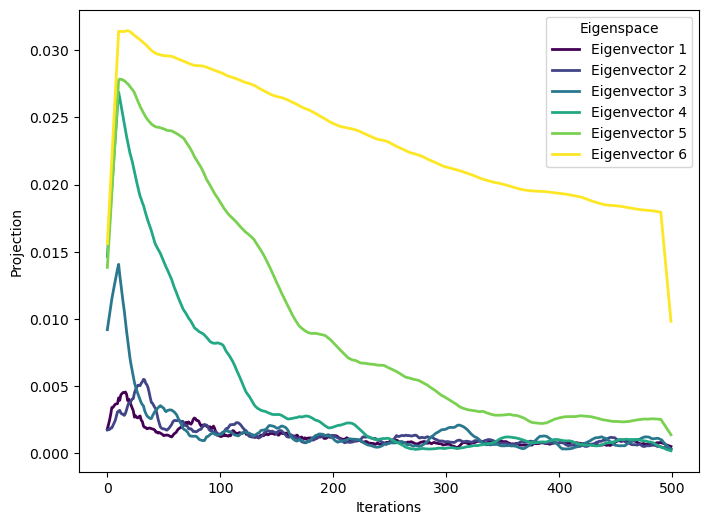

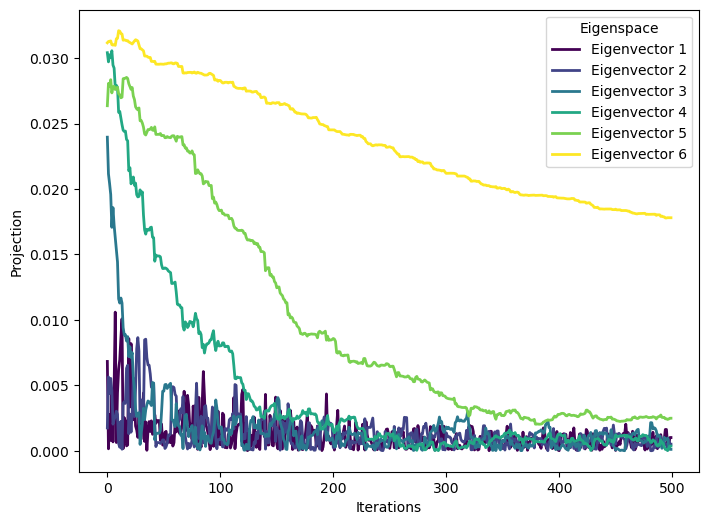

0

In [126]:
# to smooth iterates
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

smoothed = [
    moving_average(proj_iterates[k], 20) for k in range(len(rank_k))
]
# plot progress (put a very large number for top_k to see all eigenvalues)
plot_projections(smoothed, top_k=6, n=1)
plot_projections(proj_iterates, top_k=6, n=1)

Think about a matrix $A \in \mathbb{R}^{4 \times 4}$ with eigenvalues $(1, 1, 1/\kappa, 1/\kappa)$. So, $$ A = v_1 v_1 ^\top + v_2 v_2 ^\top  + \frac{1}{\kappa} (v_3 v_3 ^\top + v_4 v_4^\top)$$
where $v_i$ are mutually orthogonal unit eigenvectors. Think about $A$ as a mixture of projections orthogonal to $T = \text{span}(v_1, v_2)$ and $B = \text{span}(v_3, v_4)$, its top and bottom subspaces.



In [145]:
kappa = 5
eig = [1, 1, 1/kappa, 1/kappa]
S = np.diag(eig)
d = 4

V_rand = np.random.randn(d, 4)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
V, _ = np.linalg.qr(V_rand)

A = np.dot(V, np.dot(S, V.T))
row_norms = np.linalg.norm(A, axis=1, keepdims=True)  # Compute row-wise norms
A = A / row_norms


U, S, Vt = np.linalg.svd(A, full_matrices=False)
print(S)
print(U)
print(Vt.T)

[1.45443121 1.30270216 0.33586445 0.2734813 ]
[[-0.62385596  0.26094269  0.73548213 -0.04217453]
 [-0.40188928 -0.60541585 -0.16434718 -0.66704322]
 [-0.06138675  0.75014232 -0.35018665 -0.55757285]
 [-0.66747316  0.05164356 -0.55626015  0.49232832]]
[[-0.52478489  0.20960422  0.82315731 -0.05548816]
 [-0.38508821 -0.54338536 -0.15630674 -0.72938853]
 [-0.07208695  0.81110168 -0.28651989 -0.50480084]
 [-0.7557191   0.05396756 -0.46463598  0.45835525]]


In [128]:
# # Sadly, normalizing rows destroys the nice structure :(
# V_1, V_2 = V[:, :2], V[:, 2:]   # principal and minor eigenspace
# print(V_1.shape, V_2.shape)
# x = np.random.rand(4)
# x = x/np.linalg.norm(x)
# print("This norm is significant: ", np.linalg.norm(np.dot(A, x) - (np.dot(np.dot(V_1, V_1.T), x) + 1/kappa * np.dot(np.dot(V_2, V_2.T), x))))

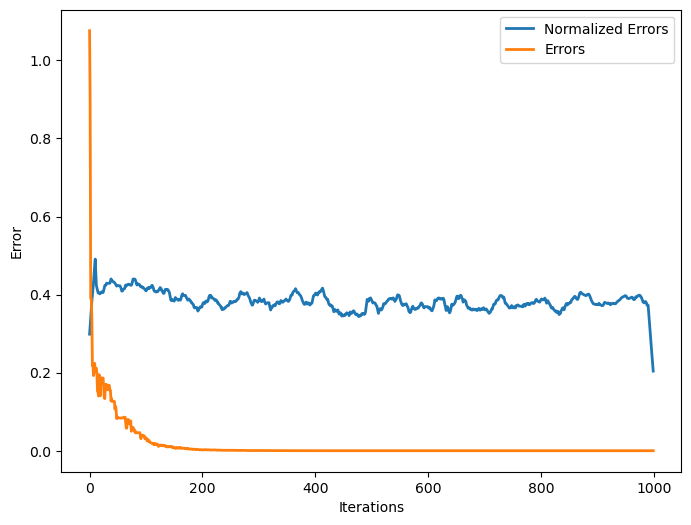

[0.9211614062952611, 0.818398781378323, 0.6730435249973198, 0.6730435249973198, 0.6023413935652491, 0.5583845357967413, 0.5583845357967413, 0.542510174218219, 0.5249953548959936, 0.5249953548959936, 0.523874612244147, 0.483874532126714, 0.483874532126714, 0.47334068249097444, 0.459452236703134, 0.4528041375913922, 0.4496581221759747, 0.4347351515972804, 0.42447003040628034, 0.416487547445393, 0.41220447707371616, 0.41220447707371616, 0.4121025436453177, 0.4121025436453177, 0.4121025436453177, 0.4016728771814838, 0.39669611566138463, 0.3943447125104508, 0.3804737731777608, 0.3804737731777608, 0.3804737731777608, 0.379584755155758, 0.3795287919460406, 0.3782771033454474, 0.3780903481989393, 0.3780903481989393, 0.3399378679798864, 0.3399378679798864, 0.30900453546492684, 0.30825096697076076, 0.27852507029524176, 0.27852507029524176, 0.27852507029524176, 0.2785221245947536, 0.2785221245947536, 0.27036080499586584, 0.2548100656868848, 0.22934787093679568, 0.20872719325545253, 0.208531356315

In [146]:
steps = 1000
b = 0 # np.random.randn(1)

iterates = kaczmarz(steps, A, b=b, n=1)

errors = [np.linalg.norm(np.dot(A, iterates[i]) - b) for i in range(len(iterates))]

normalized_iterates = [iterat/np.linalg.norm(iterat) for iterat in iterates]
normalized_errors = [np.linalg.norm(np.dot(A, normalized_iterates[i]) - b) for i in range(len(normalized_iterates))]

norms = [np.linalg.norm(iterates[i]) for i in range(len(iterates))]
nums = [i for i in range(len(iterates))]

smoothed_normalized_errors = moving_average(normalized_errors, 20)
smoothened_errors = moving_average(errors, 20)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, smoothed_normalized_errors, label=f"Normalized Errors", linewidth=2)
plt.plot(nums, errors, label=f"Errors", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print(norms)

In [147]:
# full rank case
print(normalized_errors[-10])
print("balanced between T, B: ", 1/kappa * 1 + (1 - 1/kappa) * 1/kappa)



0.3420382706403672
balanced between T, B:  0.36


[ 0.12462572 -0.22360772  0.25438223  0.84752347]


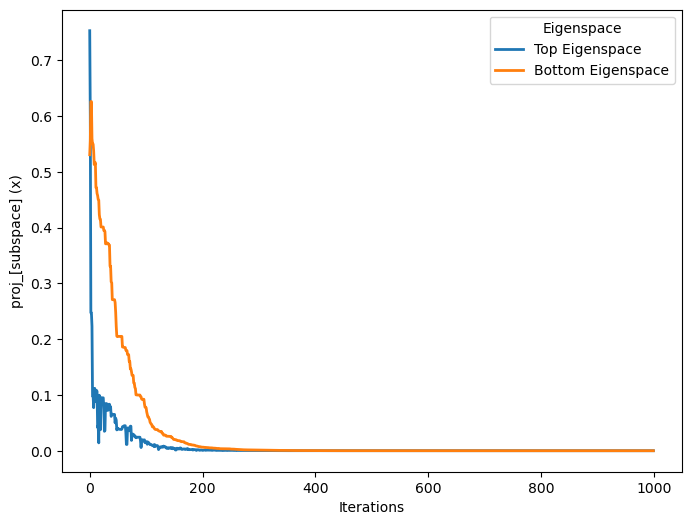

In [148]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print(iterates[0])

# Projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in iterates]

# Projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("proj_[subspace] (x)")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

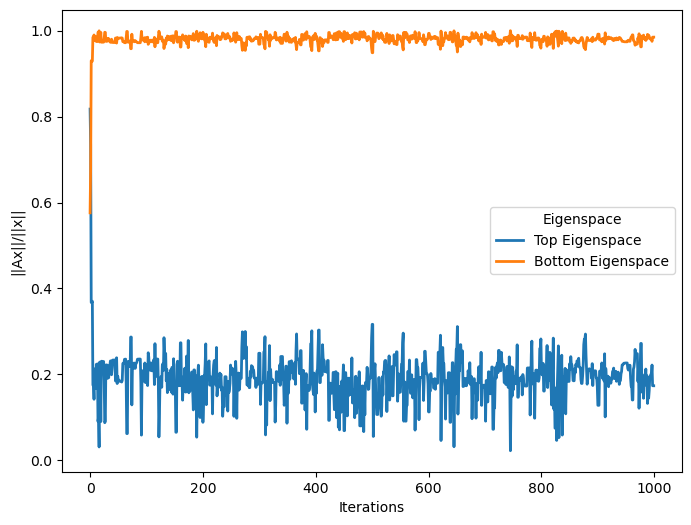

In [149]:
# Normalized projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in normalized_iterates]

# Normalized projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("||Ax||/||x||")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

In [152]:
# Do iterates in the smaller subspace "spin"?
norm_proj_2 = [(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]     # pretty much just x again, but just to be careful!
# print(norm_proj_2)
consecutive_angles = [0 for i in range(len(norm_proj_2 ) - 1)]
for i in range(1, len(norm_proj_2)):
    consecutive_angles[i-1] = np.dot(norm_proj_2[i].T, norm_proj_2[i-1])

print(consecutive_angles)

[0.9898558910434068, 0.9879862290969399, 1.0000000000000002, 0.999477304174959, 0.9970792758116938, 1.0, 0.9992008150493628, 0.9989718825085818, 0.9999999999999999, 0.9999422885388924, 0.999735844369956, 1.0000000000000002, 0.9994056929798983, 0.9988940424433701, 0.9995859672389438, 0.9997428781048394, 0.9999688188157108, 0.9992585138031125, 0.999279149768133, 0.9999980289825934, 0.9999999999999999, 0.9999903201347079, 1.0000000000000002, 1.0000000000000002, 0.9991508614847107, 0.9995282430051554, 0.9998018611259265, 0.9993651551269074, 0.9999999999999999, 0.9999999999999999, 0.999920888151828, 0.9999970843535307, 0.9998723934208513, 0.9999896312924254, 1.0, 0.9999918760496986, 1.0, 0.9977577036030909, 0.9999234744935015, 0.9999448919305123, 1.0, 1.0, 0.9999995872452461, 1.0, 0.9990507250191476, 0.9985620379802138, 0.9999158045700718, 0.9972519204487249, 0.9999736111803934, 0.9999981832210822, 0.9999998949324476, 0.9999993525714825, 0.9999997715754323, 1.0000000000000002, 0.99999985833

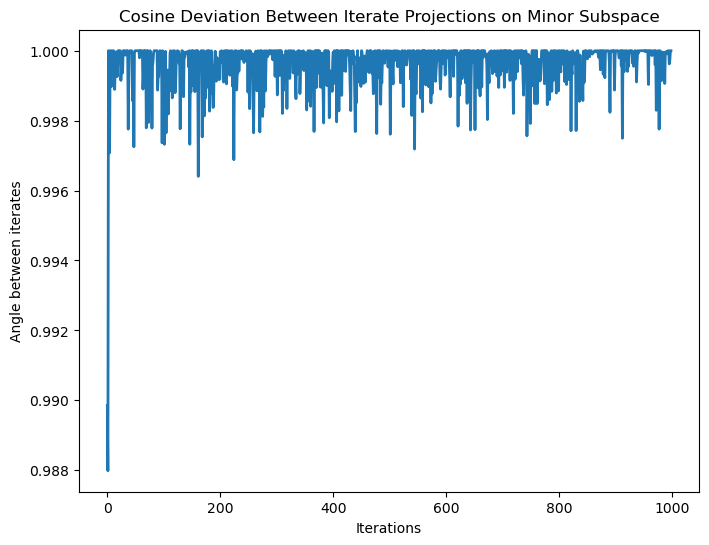

In [153]:
import matplotlib.pyplot as plt

nums = [i for i in range(len(consecutive_angles))]
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, consecutive_angles, linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Angle between iterates")
# plt.ylim(0, 1)  # Enforce y-axis range
plt.title("Cosine Deviation Between Iterate Projections on Minor Subspace")
plt.show()

In [135]:
print(np.inner(norm_proj_2[0], norm_proj_2[-1]))
print(norm_proj_2[0])
print(norm_proj_2[-1])

-0.15297725130642226
[ 0.50365046  0.00657743  0.52902229 -0.33914856 -0.41558569  0.42272349]
[-0.21305958  0.65515131 -0.21146917 -0.37632715 -0.32987558 -0.47981573]
